In [1]:
import numpy as np
from ddm_utils import *
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from scipy import integrate
import pickle
import plotly.graph_objects as go


# TODO: test the fitting with densities directly

In [2]:
# params
bound_arr = np.array([2,10]); velocity_arr = np.array([-4,-3,-2,-1,0,1,2,3,4])

# Checking why tau = 0.25 is the factor: 0.1

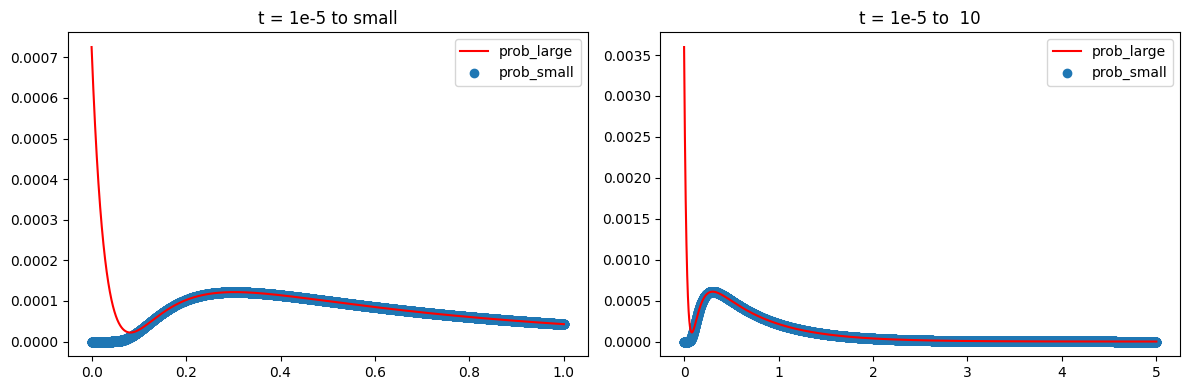

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot
t_pts = np.linspace(0.00001, 1, 10000)
v = 1; a = 2; theta = a / 2; mu = theta * v
prob_large = prob_rt_generic(t_pts, mu, rtd_mu_large_t)
prob_small = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
axs[0].plot(t_pts[:-1], prob_large, label='prob_large', color='red')
axs[0].scatter(t_pts[:-1], prob_small, label='prob_small')
axs[0].legend()
axs[0].set_title('t = 1e-5 to small')

# Right plot
t_pts = np.linspace(0.00001, 5, 10000)
prob_large = prob_rt_generic(t_pts, mu, rtd_mu_large_t)
prob_small = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
axs[1].plot(t_pts[:-1], prob_large, label='prob_large', color='red')
axs[1].scatter(t_pts[:-1], prob_small, label='prob_small')
axs[1].legend()
axs[1].set_title('t = 1e-5 to  10')

plt.tight_layout()
plt.show()


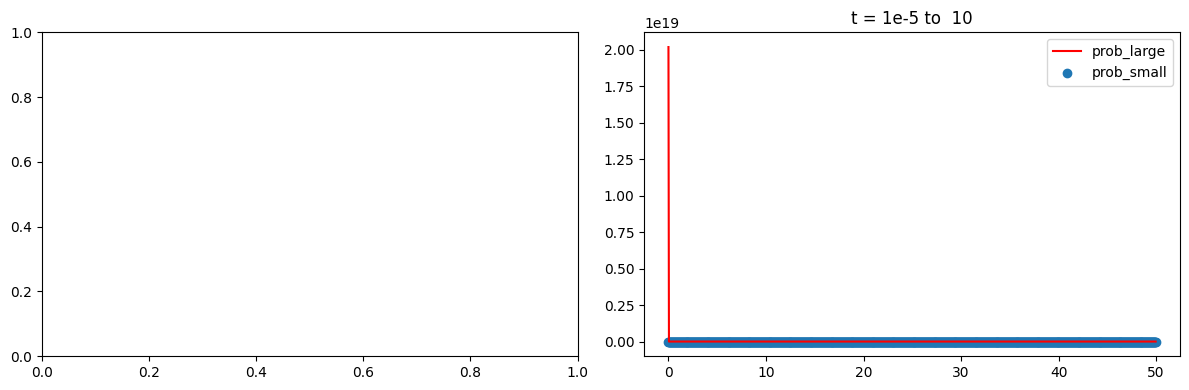

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Left plot
# t_pts = np.linspace(0.00001, 0.0005, 10000)
v = 10; a = 10; theta = a / 2; mu = theta * v; t_scale = (a**2)/4
# prob_large = prob_rt_generic(t_pts, mu, rtd_mu_large_t)
# prob_small = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
# axs[0].plot(t_pts[:-1], prob_large, label='prob_large', color='red')
# axs[0].scatter(t_pts[:-1], prob_small, label='prob_small')
# axs[0].legend()
# axs[0].set_title('t = 1e-5 to small')

# Right plot
t_pts = np.linspace(0.0001, 50, 1000)
# t_pts /= t_scale
prob_large = prob_rt_generic(t_pts, mu, rtd_mu_large_t)
prob_small = prob_rt_generic(t_pts, mu, rtd_mu_small_t)

axs[1].plot(t_pts[:-1], prob_large, label='prob_large', color='red')
axs[1].scatter(t_pts[:-1], prob_small, label='prob_small')
axs[1].legend()
axs[1].set_title('t = 1e-5 to  10')

plt.tight_layout()
plt.show()


# Generating Data

In [ ]:
N_sim = 50000;all_sim_results = {}
for a in bound_arr:
    for v in velocity_arr:
        # if a == 10 and v == 0:
        #     continue
        keyname = f"a={str(a)},v={str(v)}"
        sim_results = Parallel(n_jobs=-1)(delayed(simulate_ddm)(v, a) for _ in range(N_sim))
        all_sim_results[keyname] = sim_results

        print('completed ', keyname)

with open('all_sim_results.pkl', 'wb') as f:
    pickle.dump(all_sim_results, f)

# Reading data

In [3]:
with open('all_sim_results.pkl', 'rb') as f:
    all_sim_results = pickle.load(f)

# With mu expression

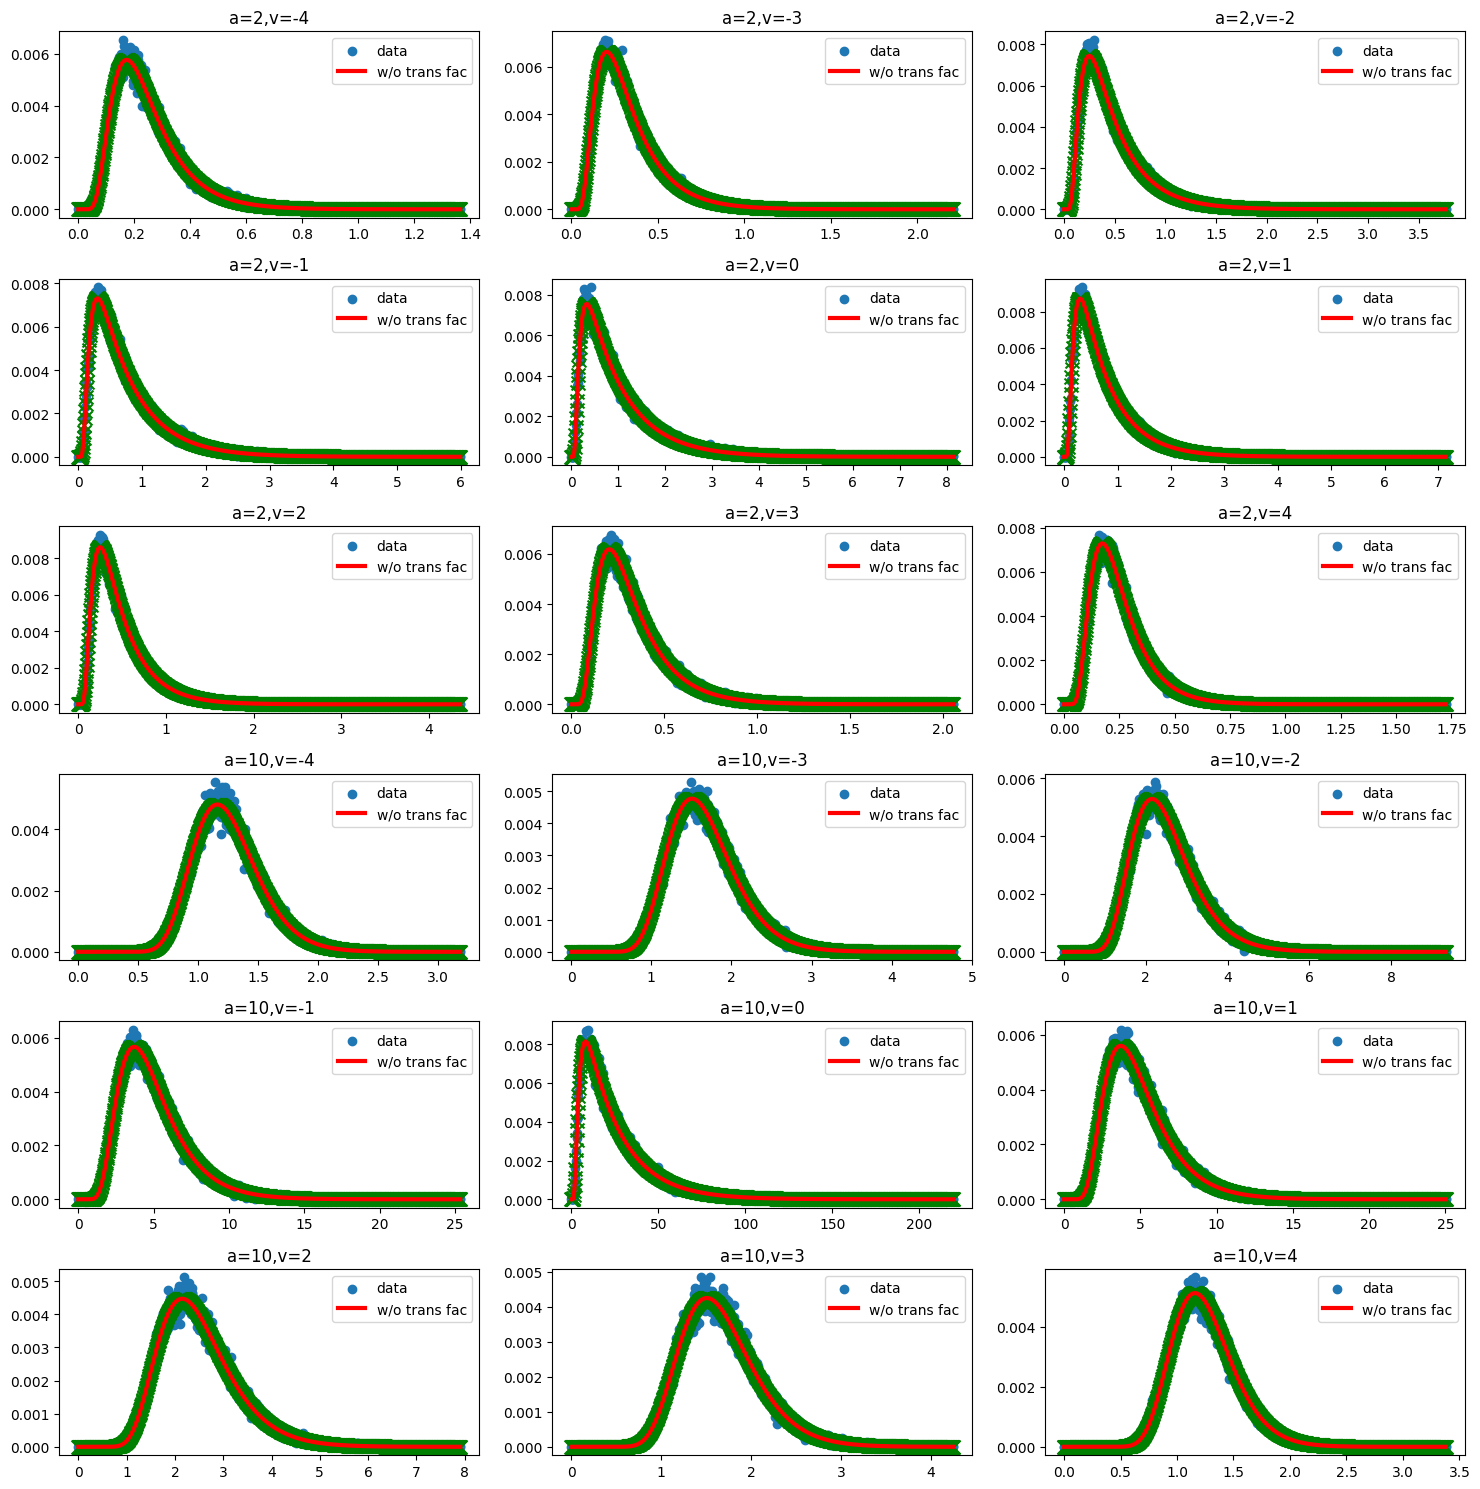

In [18]:
w = 0.5; 
fig, axes = plt.subplots(6, 3, figsize=(15, 15))
i = 0
for a in bound_arr:
    for v in velocity_arr:
        if a == 2:
            smol_2_large_trans = 0.25
        elif a == 10:
            smol_2_large_trans = 0.005

        mu = (a/2)*v
        t_scale = (a**2)/4

        
        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        t_pts = np.linspace(0.0001/t_scale, max(RTs)/t_scale, 1000)
        
        
        prob = calculate_histogram(t_pts*t_scale, RTs)
        RT_theory_1 = prob_rt_mu(t_pts, mu, smol_2_large_trans)
        RT_theory = prob_rt_generic(t_pts, mu, rtd_mu_small_t)
        

        axes[i//3, i%3].scatter(t_pts[:-1]*t_scale, prob); 
        axes[i//3, i%3].plot(t_pts[:-1]*t_scale, RT_theory,linewidth=3, color='red');
        axes[i//3, i%3].scatter(t_pts[:-1]*t_scale, RT_theory_1, color='green', marker='x', **{'s': 100});

        # if a == 10:
        #     axes[i//3, i%3].set_xlim([0, 15])
        axes[i//3, i%3].set_title(keyname); 
        axes[i//3, i%3].legend(['data', 'w/o trans fac'])
        i += 1

plt.tight_layout()
plt.show()


# Just a = 10, trials

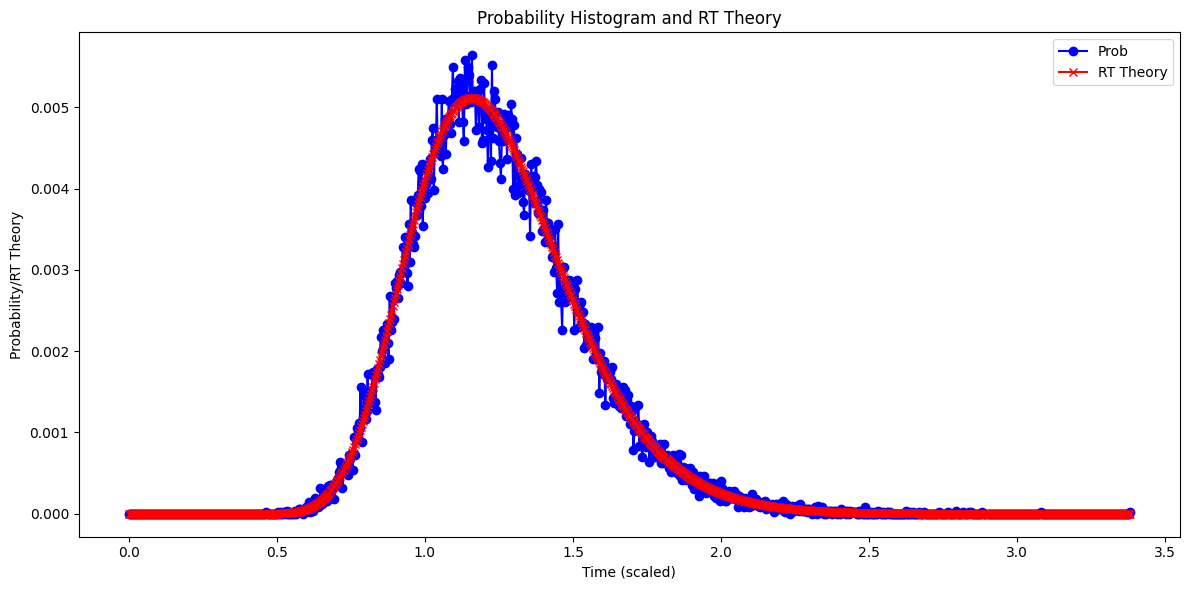

In [16]:
a = 10; v = 4
mu = (a/2)*v
t_scale = (a**2)/4


keyname = f"a={str(a)},v={str(v)}"
choices, RTs = parse_sim_results(all_sim_results[keyname])        

t_pts = np.linspace(0.0001/t_scale, max(RTs)/t_scale, 1000)


prob = calculate_histogram(t_pts*t_scale, RTs)
RT_theory = prob_rt_generic(t_pts, mu, rtd_mu_small_t)


# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot prob
ax.plot(t_pts[:-1] * t_scale, prob, color='blue', marker='o', linestyle='-', label='Prob')

# Plot RT_theory
ax.plot(t_pts[:-1] * t_scale, RT_theory, color='red', marker='x', linestyle='-', label='RT Theory')

ax.set_title('Probability Histogram and RT Theory')
ax.set_xlabel('Time (scaled)')
ax.set_ylabel('Probability/RT Theory')
ax.legend()

plt.tight_layout()
plt.show()

# a = 2, mu

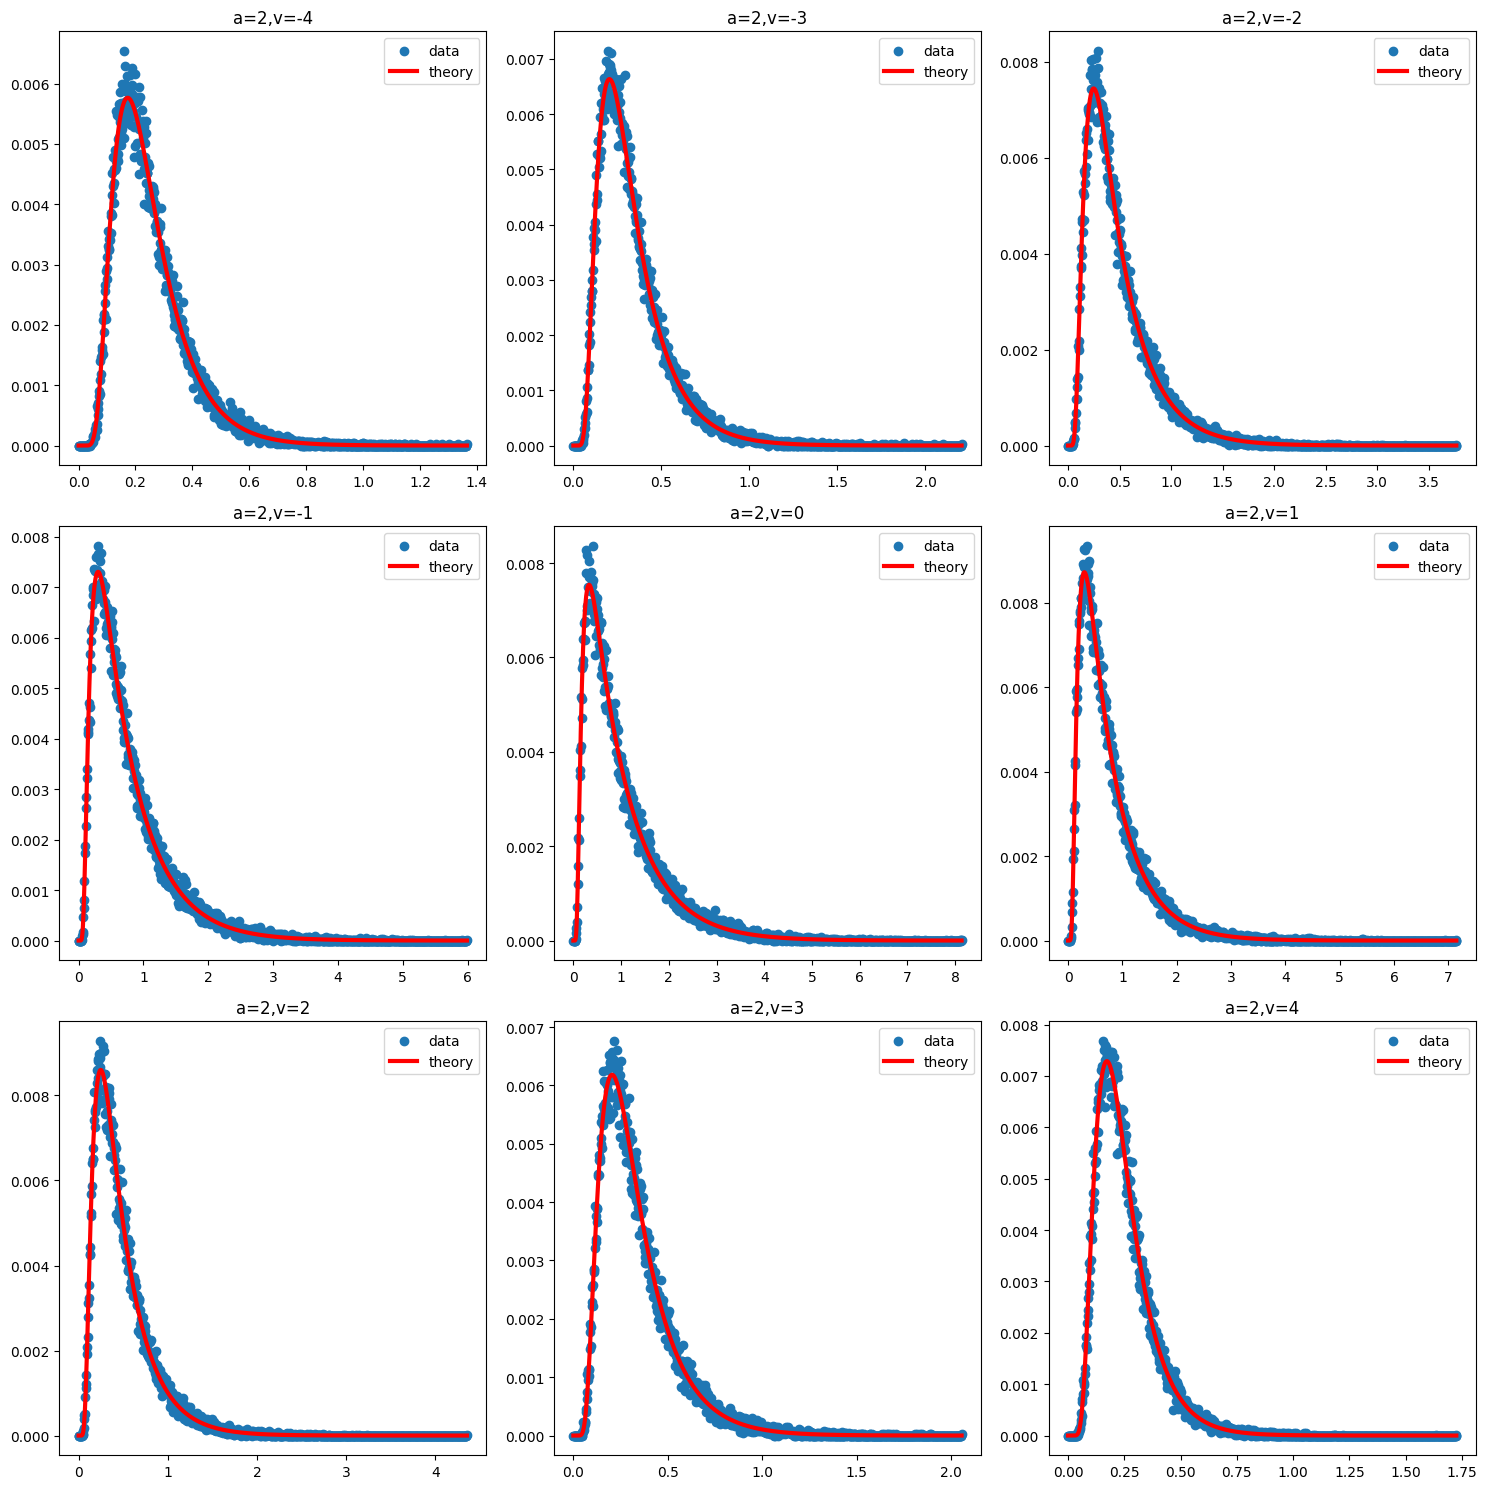

In [4]:
w = 0.5; K_max = 100
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for a in bound_arr:
    for v in velocity_arr:
        if a != 2:
            continue

        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        t_pts = np.linspace(0.0001, max(RTs), 1000)
        prob = calculate_histogram(t_pts, RTs)
        RT_theory = prob_rt(t_pts, v)

        axes[i//3, i%3].scatter(t_pts[:-1], prob); 
        axes[i//3, i%3].plot(t_pts[:-1], RT_theory,linewidth=3, color='red');
        axes[i//3, i%3].set_title(keyname); 
        axes[i//3, i%3].legend(['data', 'theory'])
        i += 1

plt.tight_layout()
plt.show()


# For a = 10: `rt_up + rt_low`



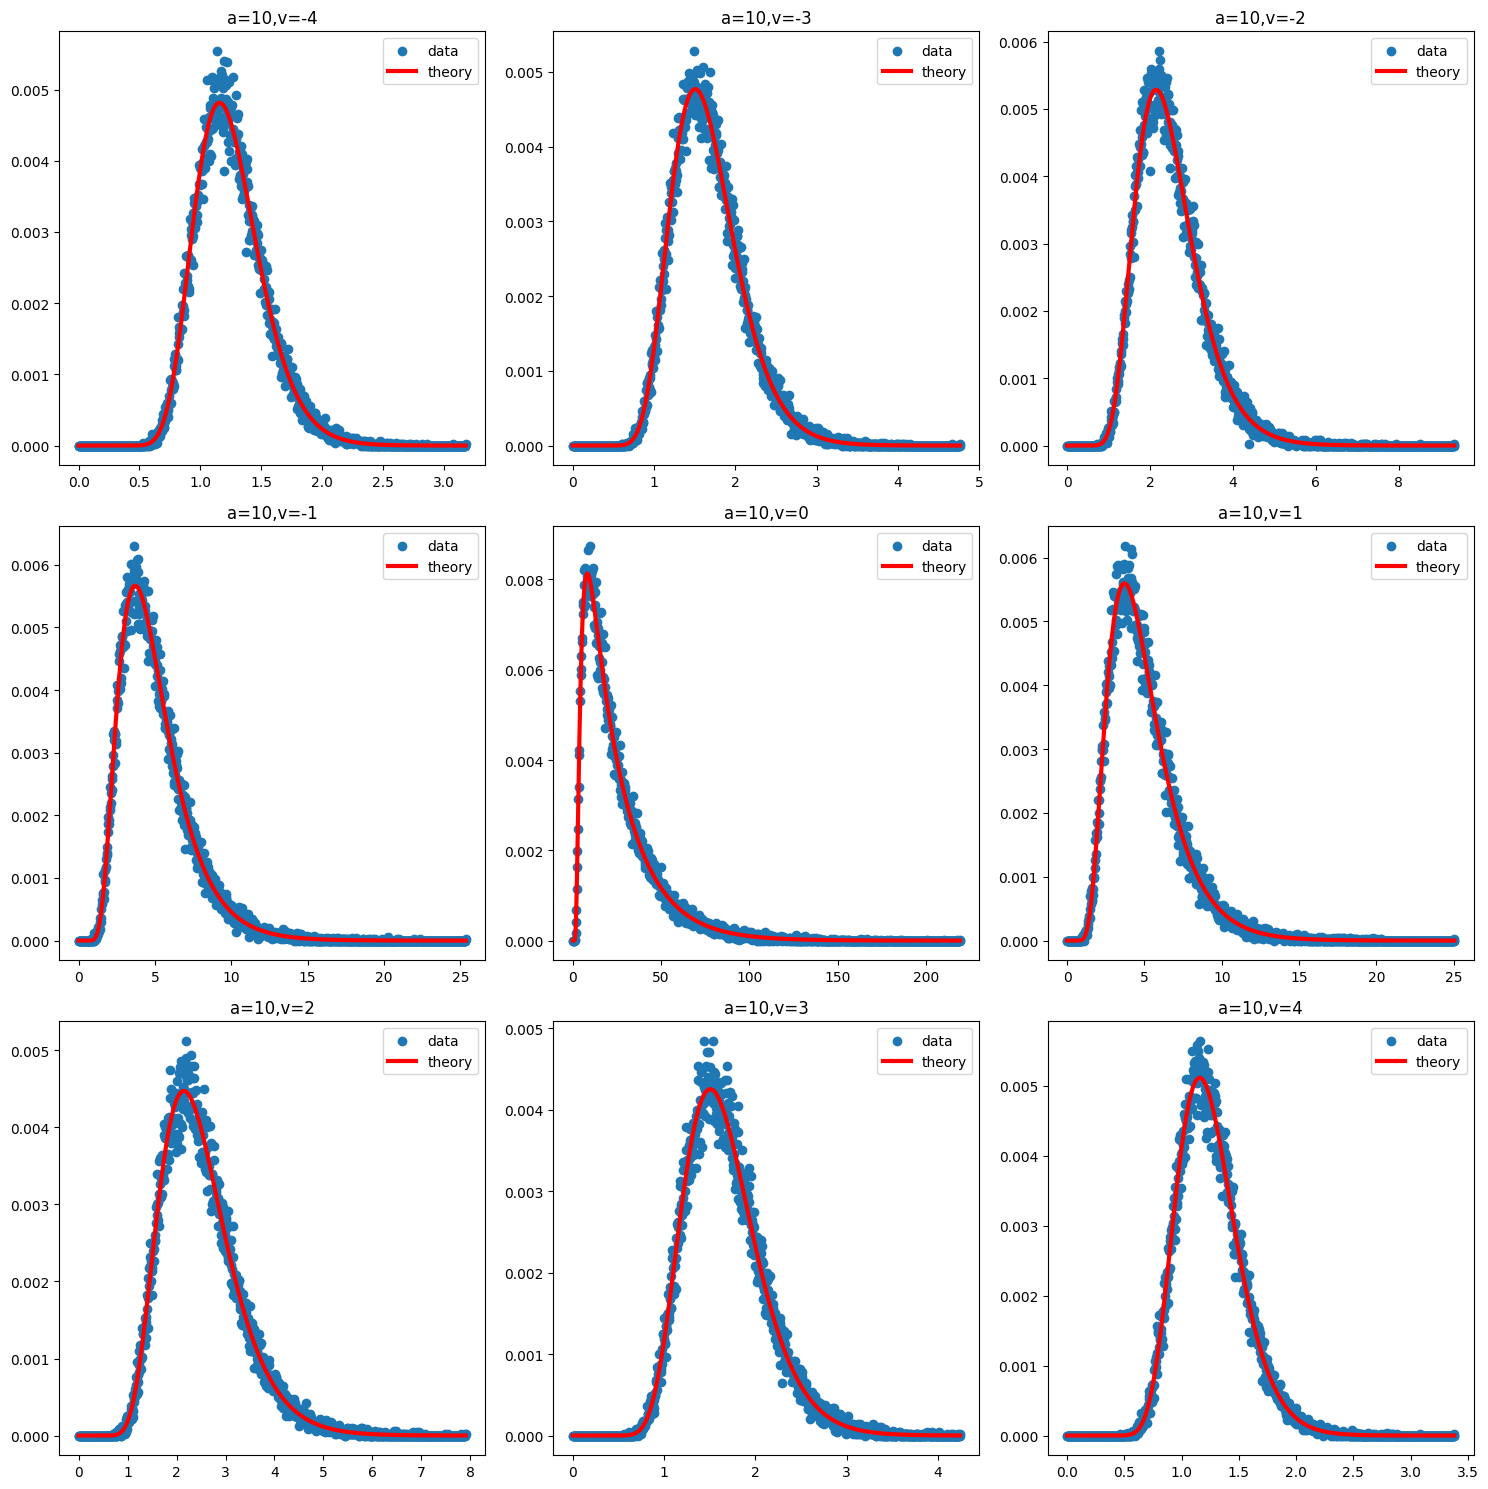

In [11]:
w = 0.5; K_max = 100
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for a in bound_arr:
    for v in velocity_arr:
        if a != 10:
            continue
        # if v == 0:
        #     continue
        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        t_pts = np.linspace(0.0001, max(RTs), 1000)
        prob = calculate_histogram(t_pts, RTs)
        RT_theory = prob_rt_a(t_pts, v, a, w) + prob_rt_a(t_pts, -v, a, 1-w)

        axes[i//3, i%3].scatter(t_pts[:-1], prob); 
        axes[i//3, i%3].plot(t_pts[:-1], RT_theory,linewidth=3, color='red');
        axes[i//3, i%3].set_title(keyname); 
        axes[i//3, i%3].legend(['data', 'theory'])
        i += 1

plt.tight_layout()
plt.show()


## a = 2 with `prob_rt_a(t_pts, v, a, w) + prob_rt_a(t_pts, -v, a, 1-w)`

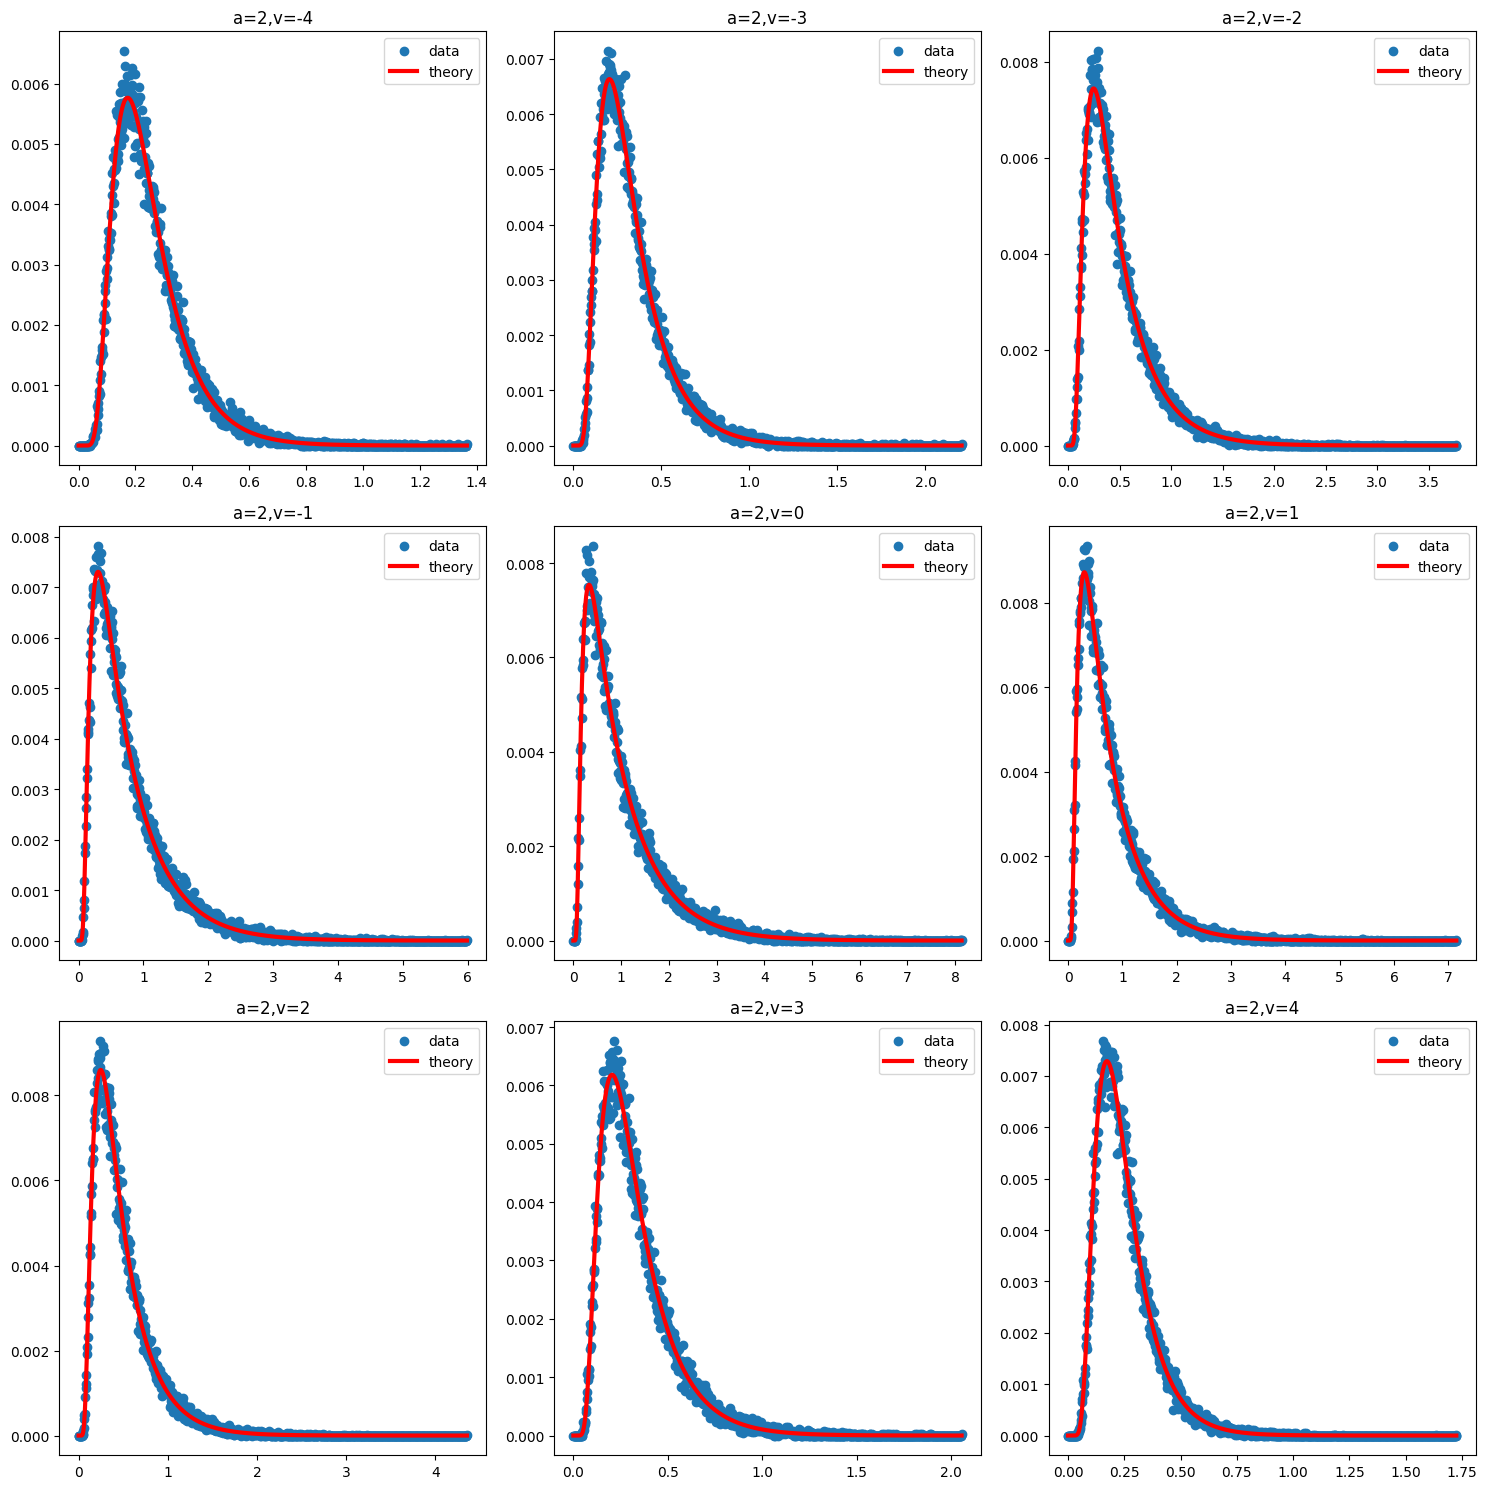

In [5]:
w = 0.5; K_max = 100
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for a in bound_arr:
    for v in velocity_arr:
        if a != 2:
            continue
        # if v == 0:
        #     continue
        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])        
        
        t_pts = np.linspace(0.0001, max(RTs), 1000)
        prob = calculate_histogram(t_pts, RTs)
        RT_theory = prob_rt_a(t_pts, v, a, w) + prob_rt_a(t_pts, -v, a, 1-w)

        axes[i//3, i%3].scatter(t_pts[:-1], prob); 
        axes[i//3, i%3].plot(t_pts[:-1], RT_theory,linewidth=3, color='red');
        axes[i//3, i%3].set_title(keyname); 
        axes[i//3, i%3].legend(['data', 'theory'])
        i += 1

plt.tight_layout()
plt.show()


# Fitting Choice

In [ ]:
w = 0.5
prob_r_a_v = np.zeros((len(bound_arr), len(velocity_arr)))
count_r_data = np.zeros((len(bound_arr), len(velocity_arr)))
for i,a in enumerate(bound_arr):
    for j,v in enumerate(velocity_arr):
        prob_r_a_v[i,j] = 1 - prob_hit_low_bound(v,a,w)

        keyname = f"a={str(a)},v={str(v)}"
        choices, RTs = parse_sim_results(all_sim_results[keyname])
        # if a == 2:
        #     print(choices.count(1), len(choices))
        count_r_data[i,j] = choices.count(1)

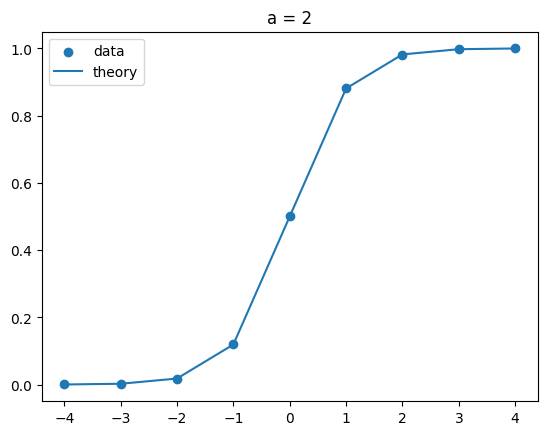

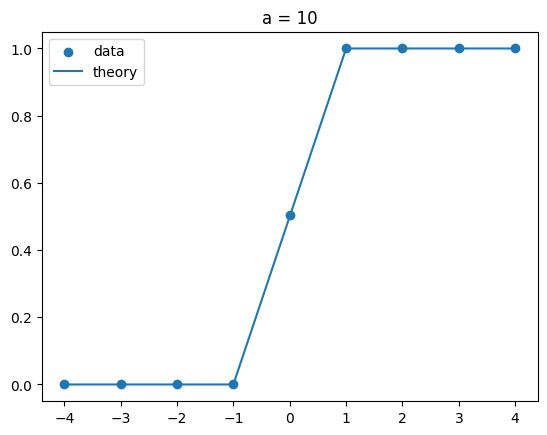

In [35]:
plt.figure()
plt.scatter(velocity_arr,count_r_data[0,:]/N_sim); plt.plot(velocity_arr, prob_r_a_v[0,:]); plt.title('a = 2'); plt.legend((['data', 'theory']));
plt.figure()
plt.scatter(velocity_arr,count_r_data[1,:]/N_sim); plt.plot(velocity_arr, prob_r_a_v[1,:]); plt.title('a = 10'); plt.legend((['data', 'theory']));